# Linear and Logistic Regression with Keras

## Setup

In [10]:
# Note: a "dependency resolver" error may occur here; ignore it.
!pip list | egrep 'keras|tensorflow |torch '
!pip install -U keras

keras                                    3.0.5
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6
tensorflow                               2.15.0
torch                                    2.1.2+cpu


In [11]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
print("Keras", keras.__version__, 'on', keras.backend.backend())
assert keras.__version__.startswith('3'), "Somehow got Keras 2; try stopping and restarting the session"
import numpy as np
np.set_printoptions(precision=3)
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

def show_weight_images(linear_layer):
    weights, bias = linear_layer.get_weights()
    weight_images = weights.T.reshape(-1, 28, 28)
    if weight_images.shape[0] == 10:
        nrow, ncol = 2, 5
    else:
        nrow, ncol = 1, 1
    with matplotlib.rc_context(rc={'image.cmap': 'RdBu'}):
        vmax = np.abs(weight_images).max()
        fig, axs = plt.subplots(nrow, ncol, squeeze=False)
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(weight_images[i], vmax=vmax, vmin=-vmax)
            ax.set(title=f'{i}')
            ax.axis('off')

Keras 3.0.5 on torch


# Data Loading

In [12]:
from keras.datasets import mnist

DATASET = 'mnist'

if DATASET == 'toy':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 3.5])[:, np.newaxis]
if DATASET == 'toy2':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 25])[:, np.newaxis]
elif DATASET == "temps":
    data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
    # Shape x to be items-by-features
    x = data.iloc[:, 0].values.astype(np.float32)[:, np.newaxis]
    # scale x to a reasonable range
    x -= 1880.0
    x /= 100.
    y_true = data.iloc[:, 1].values.astype(np.float32)[:, np.newaxis]
elif DATASET == 'mnist':
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    train_images = train_images.reshape((60000, 28 * 28))
    train_images = train_images.astype("float32") / 255
    test_images = test_images.reshape((10000, 28 * 28))
    test_images = test_images.astype("float32") / 255
    
    # Rename to match the convention of our notebook
    x, y_true = test_images, test_labels
    del train_images, train_labels
else:
    raise Exception("Unknown dataset")

Show the data (or an example item from it)

x shape (10000, 784) y_true shape (10000,)


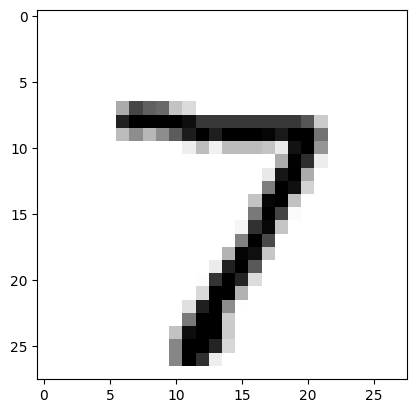

In [13]:
if len(x) < 50:
    plt.scatter(x, y_true)
elif x.shape[1] == 1:
    plt.plot(x, y_true)
else:
    with matplotlib.rc_context(rc={'image.cmap': 'gray_r'}):
        plt.imshow(x[0].reshape(28, 28))
print("x shape", x.shape, "y_true shape", y_true.shape)

# Train and Evaluate Model

In [27]:
y_true_onehot = keras.utils.to_categorical(y_true, num_classes=10)
print('one hot shape', y_true_onehot.shape)
print('one hot example:')
print(y_true_onehot[:5])

one hot shape (10000, 10)
one hot example:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [28]:
model = keras.Sequential([
    keras.layers.Input(shape=(784,)),
    keras.layers.Dense(800, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss='crossentropy',
    metrics=['accuracy'],
)
history = model.fit(x, y_true_onehot, epochs=5, validation_split=.25)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8007 - loss: 0.6708 - val_accuracy: 0.9400 - val_loss: 0.1991
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9370 - loss: 0.1991 - val_accuracy: 0.9240 - val_loss: 0.2336
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9675 - loss: 0.1117 - val_accuracy: 0.9620 - val_loss: 0.1313
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9795 - loss: 0.0709 - val_accuracy: 0.9556 - val_loss: 0.1489
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9884 - loss: 0.0422 - val_accuracy: 0.9632 - val_loss: 0.1208


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final Loss: 0.044, final weights: (800, 10), final bias: [-0.016  0.005  0.016 -0.026  0.004  0.018  0.008  0.008 -0.018 -0.001]


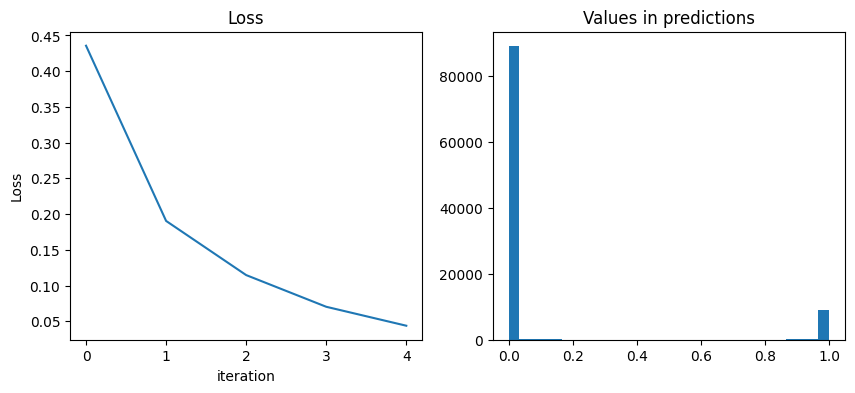

In [29]:
# Extract results from Keras
y_pred = model.predict(x)
losses = history.history['loss']
linear_layer = model.layers[-1]
weights, bias = linear_layer.get_weights()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(losses)
axs[0].set(title="Loss", xlabel="iteration", ylabel="Loss")
if x.shape[1] == 1:
    axs[1].scatter(x, y_true)
    axs[1].plot(x, y_pred, 'r');
    axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
else:
    axs[1].hist(y_pred.flatten(), bins=30)
    axs[1].set(title="Values in predictions")
print(f"Final Loss: {losses[-1]:.3f}, final weights: {weights.flatten() if len(weights.flatten()) < 25 else weights.shape}, final bias: {bias}")

In [30]:
#show_weight_images(linear_layer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<BarContainer object of 10 artists>

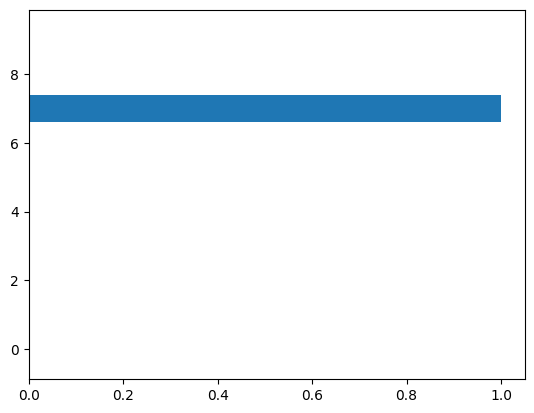

In [31]:
probs = model.predict(x[0:1])
plt.barh(np.arange(10), probs[0])

In [37]:
"""
# Step 6: Evaluating By Hand

test_predicted_probs = test_images @ weights + bias
test_predicted_probs = keras.ops.softmax(test_predicted_probs, axis=-1)
test_predicted_probs = np.array(test_predicted_probs)
weights, biases = model.layers[-1].get_weights()
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
print("Shape of test_predicted_probs:", test_predicted_probs.shape)

test_predictions = np.argmax(test_predicted_probs, axis=1)
print("Shape of test_predictions:", test_predictions.shape)
print("Shape of weights:", weights.shape)
print("Shape of biases:", biases.shape)

accuracy = np.mean(test_predictions == test_labels)
error_rate = 100 - (accuracy * 100)
print("Accuracy:", accuracy)
print("Error Rate:", error_rate)
print("Validation Loss:", val_loss[-1])
print("Validation Accuracy:", val_accuracy[-1])
"""

#Step 7: Going Deeper
w1, b1 = model.layers[-2].get_weights()
w2, b2 = model.layers[-1].get_weights()

layer1_output = x @ w1 + b1
layer1_output_relu = np.maximum(layer1_output, 0)

test_predicted_probs_deeper = layer1_output_relu @ w2 + b2
test_predicted_probs_deeper = keras.ops.softmax(test_predicted_probs_deeper, axis=-1)
test_predicted_probs_deeper = np.array(test_predicted_probs_deeper)  # Convert to NumPy array

test_predictions_deeper = np.argmax(test_predicted_probs_deeper, axis=1)

accuracy_deeper = np.mean(test_predictions_deeper == test_labels)
error_rate_deeper = 100 - (accuracy_deeper * 100)

print("Test Accuracy of Deeper Model:", accuracy_deeper)
print("Error Rate of Deeper Model:", error_rate_deeper)

Test Accuracy of Deeper Model: 0.989
Error Rate of Deeper Model: 1.0999999999999943


# Analysis

| Model Description                    | Prediction Equation | Weights shape | Biases shape | Loss Function | Validation Loss | Validation Accuracy |
|------------------------------------|----------------------|---------------|--------------|----------------|-----------------|----------------------|
| 2. Linear regression (one number output) | `y = x @ W + b` | (784, 1) | (1,) | MSE | 0.03278 | 0.1441 |
| 3. Linear regression (10 number output) | `y = x @ W + b` | (784,10) | (10,) | MSE | 0.0491 | 0.8114 |
| 4. Linear regression (10 number output w/ Softmax) |  `y = softmax(x @ w + b)`  | (784,10) | (10,) | MSE | 0.0121 | 0.9211 |
| 5. Logistic Regression | `y = softmax(x @ w + b)` | (784,10) | (10,) | Cross-Entropy | 0.2884 | 0.9219 |
| 6. Evaluating By Hand | `y = softmax(x @ w + b)` | (784,10) | (10,) | Cross-Entropy | 0.2675 | 0.9268 |
| 7. Going Deeper(2-layer NN, 800 HU, Cross-Entropy Loss) | `y = softmax(relu(x @ w1 + b1) @ w2 + b2)` | (784, 800) | (800,) | Cross-Entropy | 0.0199 | 0.989|


# Narative

1. Describe how its training setup was different from the prior one.
- Step 2: Model predicts a single output number
- Step 3: Model predicts 10 output numbers
- Step 4: Model applies softmax activation to the output layer
- Step 5: Model utilizes logistic regression instead of linear regression. It also uses cross-entropy loss function
- Step 6: Model uses manual evaluation
- Step 7: Model uses a deeper neural network with two hidden layers(800 hidden units). It also uses ReLu function.
2. Describe why that difference should lead to an improvement in the results.
- Step 2: Only having the model predict just one value makes it difficult for the model to predict the correct value of the data
- Step 3: The change from predicting just one value to predicting 10 helps the model understand the data better, which might make it better at guessing the right answer
- Step 4: Turning the model's guesses into probabilities allows it to be easier to understand and use them for deciding which category something belongs to
- Step 5: Changing to a different type of model that's good at sorting things into categories and using a different way to measure how well the guesses are make the guesses better
- Step 6: Checking the model's guesses by hand helps us understand why it's making certain guesses. It helps us figure out how to make it better.
- Step 7: Adding more layers and connections to the model makes it better at understanding complicated patterns in the data. This will help it make better guesses
<br>
3. Give an example of what its predictions might look like (e.g., “floating-point numbers usually between -1 and 9.8”), and describe why that makes sense given the way we set up this model.
- Step 2:
  - Floating-point numbers usually between -2.5 and 13
  - These predictions make sense because the model is predicting a single value, which can widely vary based on the input features
- Step 3:
  - Floating-point numbers usually between -0.6 and 1.4
  - These predictions make sense because the model's outputs represent the regression values for each class. These range from -1 to 1 because of linear regression.
- Step 4:
  - Floating-point numbers usually between 0.0 and 0.9
  - These predictions make sense because
- Step 5:
  - Floating-point numbers usually between 0.0 and 0.1
  - Due to the softmax activation function, the predictions make sense because they represent the probabilities of each class, from 0 to 1.
- Step 6:
  - Floating-point numbers usually between 0.0 and 1.0
  - Due to the softmax activation function, the predictions make sense because they represent the probabilities of each class, from 0 to 1.
- Step 7:
    - Floating-point numbers usually between 0.0 and 1.0
    - Due to the softmax activation function, the predictions make sense because they represent the probabilities of each class, from 0 to 1.
    
4. Describe how its accuracy differs from the previous one.
- Step 2: We started off with a very low accuracy with only 0.1441. There was a lot of room for improvement
- Step 3: There was a big increase in accuracy because if went from 0.1441 to 0.8114. So we were heading in the right direction
- Step 4: I would also say applying step 4 to our model increased our accuracy greatly. It went from 0.8114 to 0.9211. Again, we are moving in the right direction in training our model
- Step 5: There was only a slight increase in our model's accuracy in this step. We increased from 0.9211 to 0.9219. So only a 0.0008 increase.
- Step 6: Again, there was only a slight increase in our model, but more than the previous step. So, it increased from 0.9219 to 0.9268.
- Step 7: The accuracy significantly improved compared to previous steps. It increased from 0.9268 to 0.989. This is due to the increased model complexity.

# General Questions

1. How is the softmax operation useful in classification?<br>
The softmax operation is useful in classification because it has the capability to transform the output of a model into probabilities. This allows the predicted values to sum up to 1 across all classes. Consequently, it provides a meaningful interpretation for each class's likelihood and helps identify the most probable class.<br>
<br>
2. Suppose an interviewer asks you “What’s the difference between linear regression and logistic regression?” Describe at least two differences you could mention.
- **Output type**: Linear regression predits coninuous munerical values,m amking it suitable for regresion tasks where the target variable is continous. In contrast, logistic regression predicts the probability of a binary outcome, like 0 or 1, making it ideal for classification tasks
- **Model Function**: Linear regression employs a linear function to model relationships, while logistic regression uses the logistic sigmoid function for probability estimation
<br>
3. The weight images helped us see that even though some of the models were getting good accuracy, they were doing so for the wrong reasons. Consider the weight images for the logistic regression model (Step 5). Why did the weights look vaguely like the digits? Why did the weights look not exactly like the digits?<br>
When considering the weight images for the logistic model (Step 5), the weights looked vaguely like the digits because our model learned to emphasize the important features of the digits for classification. This meant that it may resemble certain aspects of the digits. However, the weights did not look exactly like the digits because logistic regression is a linear model. This resulted in the weight images not capturing the intricate relationships in the data.